# Project Introduction

This is a Udacity project set to demonstrate data gatherig and data wrangling skills.
Data sets:
1. Twitter archive of WeRateDogs tweets (provided by Udacity)
2. Twitter original data will be gathered via Tweepy API using a Tweeter developer account. This data will contain retweet and favourite counts that are omitted in the provided WeRateDogs Twitter archive.
3. Image prediction of pictures on these tweets: this is a Udacity dataset that is created as part of their Machne Learning nanodegree

The project will involve cleaning those datasets to meet tidy data standards.
[https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html]

Then analysis on the master dataset of the merged datasets above will be performed.

# Gather
## Import all necessary libraries

In [1]:
# import all necessary libraries
import requests
import pandas as pd
import numpy as np
import tweepy
from timeit import default_timer as timer
import json
from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns
import itertools
import scipy.stats as stats
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

## Define functions

### Functions for gathering tweet data via Tweepy API

In [2]:
def arrange_tweet_bins(tweet_ids):
    """
    This function cuts tweet ids found in Twitter WeRateDogs archive in bins of 100 tweets.
    This will help to gather tweet data without delays enforced by Tweepy for a longer array of tweets
    @param: tweet_ids - array of all tweet id found in the Tweeter archive
    """
    bins = np.arange(0, len(tweet_ids), 100)
    bins = np.append(bins, [len(tweet_ids)])
    return bins

In [3]:
# created with guidance from this StackOverflow post:
# https://stackoverflow.com/questions/28384588/twitter-api-get-tweets-with-specific-id/43835148#43835148?newreg=9ae89fc03ae448a7be97e976095cce73
def collect_tweet_data(tweet_ids, bins, is_debug_mode):
    """
    Query Twitter's API for JSON data for each tweet ID in the Twitter archive
    @param: tweet_ids - array of all tweet id found in the Tweeter archive
    @param: bins - array of tweet id cuts. Each bin is a cut of 100 tweet ids
    @param: is_debug_mode - if True, will print tweet id that was successfully extracted
                          - if False, it will be no printing on the screen.  
    @return: None
    """
    count = 0
    failed_tweet_dict = {}
    start = timer()
    # Save each tweet's returned JSON as a new line in a .txt file
    with open('tweet_json.txt', 'w') as json_outfile:
        # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
        for i in range(len(bins)-1):
            tweet_id_list = list(tweet_ids[bins[i]: bins[i+1]])
            #tweet_id_list.to_list()
            try:
                tweet_list = api.statuses_lookup(id_= tweet_id_list, include_entities=False, trim_user=True)
            except tweepy.TweepError as e:
                print("Fail")
                failed_tweet_dict[tweet_id] = e
                pass

            for tweet in tweet_list:
                count += 1
                if is_debug_mode:
                    print(str(count) + ": " + str(tweet.id))
                    print("Success")
                json.dump(tweet._json, json_outfile)
                json_outfile.write('\n')
                
        # write failed tweets into a file
        with open('tweet_json_new_failed.txt', 'w') as tweet_json_failed_outfile:
            tweet_json_failed_outfile.write(str(failed_tweet_dict))
            tweet_json_failed_outfile.close()
        # close file with successfully gathered tweets
        json_outfile.close()
    end = timer()
    print(end - start)
    return None

In [4]:
def parse_tweet_json_file_to_df(json_file):
    """
    parses tweet JSON file and creates a data frame from dictionary list
    @param: json_file - this is the input file with data collected via Tweepy
    @return: pandas data frame with data collected via Tweepy
    """
    df_tweet_list = []
    with open(json_file, 'r', encoding='utf-8') as file:
        for tweet_line in file:
            json_item = json.loads(tweet_line)
            # Append to list of dictionaries
            df_tweet_list.append({'tweet_id': json_item['id'],
                            'retweet_count': json_item['retweet_count'],
                            'favorite_count': json_item['favorite_count'] #,
                            #'text': json_item['text']
                           })
    # Create DataFrame from list of dictionaries
    df_tweets_columns = ['tweet_id', 'retweet_count', 'favorite_count']
    df_parsed_tweets = pd.DataFrame(df_tweet_list, columns = df_tweets_columns)
    df_parsed_tweets = df_parsed_tweets.sort_values('tweet_id').reset_index(drop=True)
    return df_parsed_tweets
        

### Cleaning Functions

In [5]:
def extract_source(row):
    """
    The function extracts value of <a> tag of `source` column in the Twitter archive 
    @param: row - a row from the dataframe where this function is applied
    @return: value of <a> tag of `source` colum
    """
    soup = BeautifulSoup(str(row['source']))
    return soup.find('a').contents[0]

In [6]:
def clean_dog_name(row, not_name_list):
    """
    The function cleans `name` column in the Twitter archive.
    @param: row - a row from the dataframe where this function is applied
    @param: not_name_list - list of found values in `name` column that are not dog names
    @return: 
        - if `name` is found in `not_name_list`, then return default value 'A good dog'
        - if `name` is not found in `not_name_list`, return capitilised value of `name`    
    """
    dirty_name = str(row['name'])
    if dirty_name in not_name_list:
        # return a default value. Might use np.NaN instead
        return 'A good dog'
    else:
        return dirty_name.capitalize()

In [7]:
def clean_dog_stage(row):
    """
    The function evaluates dog stage value that will be used as a single value
    instead of four coulums column in the Twitter archive:
        - 'doggo', 'pupper', 'puppo', 'floofer'
        - None values in these columns will be replaced with empty string
    @param: row - a row from the dataframe where this function is applied
    @return: 
        - concatenated value of the above columns
        - if the concatenated value is an empty string, returns default value 'doggo'
    """
    # 'doggo', 'pupper', 'puppo'
    doggo = str(row['doggo']).replace('None', '')
    pupper = str(row['pupper']).replace('None', '')
    puppo = str(row['puppo']).replace('None', '')
    floofer = str(row['floofer']).replace('None', '')
    dog_stage = doggo + pupper + puppo + floofer
    if dog_stage == '':
        return 'doggo' # default value
    else:
        return dog_stage
    

In [8]:
def calc_best_prediction(row):
    """
    The function selects prediction with the highest confidence
    @param: row - a row from the dataframe where this function is applied
    @return:
        - dog breed predicted with the highest confidence
        - if neither of predictions is a dog breed, the function returns 'no dog predicted'
    """
    p1_dog = row.p1_dog
    p2_dog = row.p2_dog
    p3_dog = row.p3_dog
    
    prediction_dict = {}
    no_prediction_dict = {}
    if p1_dog:
        prediction_dict['p1'] = row.p1_conf
    else:
        no_prediction_dict['p1'] = row.p1_conf
        
    if p2_dog:    
        prediction_dict['p2'] = row.p2_conf
    else:
        no_prediction_dict['p2'] = row.p2_conf
        
    if p3_dog:
        prediction_dict['p3'] = row.p3_conf
    else:
        no_prediction_dict['p3'] = row.p3_conf    
        
    # get the key with highest confidence value        
    if len(prediction_dict) == 0:
        return 'no dog predicted'
    else:
        max_conf = max(prediction_dict, key=prediction_dict.get)
        return str(row[max_conf]).lower().replace('_', ' ')

### Visualisation functions

In [9]:
# this is a plotting function for a dataframe that present correlation between rating and an input column
def plot_categorical_data(df_to_plot, factor_column, cor_factor_column, rownum, plot_size):
    """
    @param: input_df - dataframe for plotting
    @param: factor_column - quantitive factor; will be plotted on y axis
    @param: cor_factor_column - categorical column that is anlyzed to be correlated to movie's popularity
    @param: rownum - number of records for plotting will be supplied to head()
    @plot_size: control size of the plot
    """
    df_to_plot.sort_values(factor_column, axis=0, ascending=False, 
                        inplace=True, kind='quicksort', na_position='last')
    f,ax = plt.subplots(figsize = (plot_size,plot_size))
    b = sns.barplot(x=cor_factor_column, y=factor_column,
                    data=df_to_plot.head(rownum), ax=ax)
    ticks = plt.setp(ax.get_xticklabels(),rotation=90)
    b.tick_params(labelsize=8)
    b.axes.set_title(factor_column + " vs " + cor_factor_column, fontsize = 20)
    plt.show()
    return None

### Download image predictions file

Two code snipets below will download image prediction neural network extract 'image-predictions.tsv' provided by Udacity

In [10]:
# Predictions Url
predictions_url = ' https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
predictions_filename = 'image-predictions.tsv'

In [11]:
# Download predictions file
r = requests.get(predictions_url)
with open(predictions_filename, 'wb') as f:
        f.write(r.content)

## Load data into pandas data frames

Two code snippets below will load Udacity provided data sets into pandas data frames.
This step is pre-requisite to query and save tweet data using Tweepy API. 

In [12]:
# load image predictions data into a pandas dataframe
df_img_predictions = pd.read_csv(predictions_filename, sep ='\t')

In [13]:
# load the provided WeRateDogs archive csv data into a pandas dataframe
df_tw_archive = pd.read_csv('twitter-archive-enhanced.csv')

## Gather Tweepy Data 

Following code sections will collect WeRateDogs tweet data using Tweepy API

### Declare tweepy keys 

In [14]:
# tweepy keys to download Tweeter data
consumer_key = 'YOUR CONSUMER KEY'
consumer_secret = 'YOUR CONSUMER SECRET'

access_token = 'YOUR ACCESS TOKEN'
access_secret = 'YOUR ACCESS SECRET'

#### Authenticate

In [15]:
# Tweepy authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

#### Gather tweet data into a file

In [16]:
# 1. get list of tweeter ids from the archive that was loaded to `df_tw_archive` data frame
tweet_archive_ids = df_tw_archive.tweet_id.values
# 2. create bins - arrays of 100 tweet ids in order not to experience pauses during download
bins = arrange_tweet_bins(tweet_archive_ids)
# 3. query Tweepy and write successfully extracted tweet data into `tweet_json.txt`
collect_tweet_data(tweet_archive_ids, bins, False)

17.776953245


#### Parse `tweet_json.txt` and store extracted tweet data in a pandas data frame 

In [17]:
# 4. parse JSON file and store in a pandas dataframe
df_tweets = parse_tweet_json_file_to_df('tweet_json.txt')

## Assessment

### Assessment of image prediction data
#### Visual Assessment

In [18]:
# view the dataframe using Jupiter viewer and then open in Excel or Google Sheets
df_img_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


##### Notes
* values in p1, p2, p3 columns are mixed case. Some are lower case some are capitalized.
* underscore in these columns looks unnecessary

#### Programmatic assessment

In [19]:
# assessing null values and column datatypes
df_img_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


Notes:
* there are no null values in the data frame
* best predicted dog breed value can be formed as a value of all p1/p2/p3 image prediction related columns

### Assessment of Tweeter Archive csv data
#### Visual Assessment

In [20]:
# this line will show top 5 and bottom 5 records in the tweeter archive data
df_tw_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


_Noticed Issues:_
* source column looks convoluted and its value can be simplified to value in href element. HTML markup is unnecessary for analysing data in this table
* floofer column is misspelled
* columns doggo, floofer, puppo, pupper represent 2 variables in 4 columns. Floof is not really a dog stage but rahther an indicator if a dog has lots of fur or not

#### Programmatic assessment

##### Assessing null values and column types

In [21]:
# assessing data formats and missing values
df_tw_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [22]:
# additional sample assessment to get more a random pick
df_tw_archive.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1714,680440374763077632,NaN,NaN,2015-12-25 17:30:01 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Merry Christmas. My gift to you is this tiny u...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680440374...,11,10,None,None,None,None,None
1817,676603393314578432,NaN,NaN,2015-12-15 03:23:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Godzilla pupper. He had a ruff childho...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/676603393...,9,10,Godzilla,None,None,pupper,None
2024,671891728106971137,NaN,NaN,2015-12-02 03:20:45 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Mojo. Apparently he's too cute for a s...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671891728...,11,10,Mojo,None,None,None,None
1431,697516214579523584,NaN,NaN,2016-02-10 20:23:19 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",Say hello to Pherb. He does parkour. 9/10 http...,NaN,NaN,NaN,https://vine.co/v/i1LriMBmX6W,9,10,Pherb,None,None,None,None
807,771908950375665664,NaN,NaN,2016-09-03 03:13:29 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Doggo will persevere. 13/10\nhttps://t.co/yOVz...,NaN,NaN,NaN,https://twitter.com/yahoonews/status/771905568...,13,10,None,doggo,None,None,None
534,807106840509214720,NaN,NaN,2016-12-09 06:17:20 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Stephan. He just wants to help. 13/10 ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/807106840...,13,10,Stephan,None,None,None,None
2190,668960084974809088,NaN,NaN,2015-11-24 01:11:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jaycob. He got scared of the vacuum. Hide...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668960084...,10,10,Jaycob,None,None,None,None
745,780092040432480260,NaN,NaN,2016-09-25 17:10:10 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Hank. He's mischievous ...,7.533757e+17,4.196984e+09,2016-07-13 23:48:51 +0000,https://twitter.com/dog_rates/status/753375668...,8,10,Hank,None,None,None,None
1185,718613305783398402,NaN,NaN,2016-04-09 01:35:37 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Carper. He's a Tortellini Angiosperm. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/718613305...,11,10,Carper,None,None,None,None
564,802323869084381190,NaN,NaN,2016-11-26 01:31:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Severus. He's here to fix your cable. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/802323869...,13,10,Severus,None,None,None,None


In [23]:
# assessing duplicates
df_tw_archive[df_tw_archive.duplicated(['tweet_id'], keep=False)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


##### Noticed issues:
* there are 181 retweets that shall be removed as this analysis required only original tweets with ratings
* there are 78 records that are replies to other tweets. `expanded_urls` contains multiple repetetive urls.
* `timestamp` has string format, not date time format

#### `source` column assessment

This column looked convoluted visually however it was noticed that it hold value of a platform used for tweet posting. 

In [24]:
# assessment what values source column has. 
df_tw_archive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

Therefore, `source` can be simplified as listed value of: 
* Twitter for iPhone
* Vine - Make a Scene
* Twitter Web Client
* TweetDeck

#### Assessing columns floofer, doggo, pupper, puppo
Firstly, let's have a look what values each of this column has:

In [25]:
# listed values in 'doggo' column
df_tw_archive.doggo.value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [26]:
# listed values in 'pupper' column
df_tw_archive.pupper.value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [27]:
# listed values in 'puppo' column
df_tw_archive.puppo.value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

In [28]:
# listed values in 'floofer' column
df_tw_archive.floofer.value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [29]:
# asessing records with not None 'floofer' value 
df_tw_archive.query('floofer=="floofer"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
46,883360690899218434,NaN,NaN,2017-07-07 16:22:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Grizzwald. He may be the floofiest floofe...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/883360690...,13,10,Grizzwald,None,floofer,None,None
200,854010172552949760,NaN,NaN,2017-04-17 16:34:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...","At first I thought this was a shy doggo, but i...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/854010172...,11,10,None,doggo,floofer,None,None
582,800388270626521089,NaN,NaN,2016-11-20 17:20:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Doc. He takes time out of every day to...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/800388270...,12,10,Doc,None,floofer,None,None
774,776218204058357768,NaN,NaN,2016-09-15 00:36:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Atlas rolled around in some chalk and now he's...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/776218204...,13,10,None,None,floofer,None,None
984,749317047558017024,NaN,NaN,2016-07-02 19:01:20 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Blu. He's a wild bush Floofer. I wish ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/749317047...,12,10,Blu,None,floofer,None,None
1022,746542875601690625,NaN,NaN,2016-06-25 03:17:46 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",Here's a golden floofer helping with the groce...,NaN,NaN,NaN,https://vine.co/v/5uZYwqmuDeT,11,10,None,None,floofer,None,None
1091,737445876994609152,NaN,NaN,2016-05-31 00:49:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Just wanted to share this super rare Rainbow F...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/737445876...,13,10,None,None,floofer,None,None
1110,733822306246479872,NaN,NaN,2016-05-21 00:50:46 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Moose. He's a Polynesian Floofer. Dapp...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/733822306...,10,10,Moose,None,floofer,None,None
1534,689993469801164801,NaN,NaN,2016-01-21 02:10:37 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",Here we are witnessing a rare High Stepping Al...,NaN,NaN,NaN,https://vine.co/v/ienexVMZgi5,12,10,None,None,floofer,None,None
1614,685307451701334016,NaN,NaN,2016-01-08 03:50:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Petrick. He's an Altostratus Floo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/685307451...,11,10,Petrick,None,floofer,None,None


Notes:

These 4 columns can be simplified to one representing type of a dog.

There is one record where 'floofer' might not be a correct value because the dog on the tweet doesn't look like having extra fur.
There are also records with multipple dog stages, and after asessing visually it can make sense if two or more dogs were on a tweet.


#### Assessing rating numerator and denominator

In [30]:
# what are the values, how much they vary
df_tw_archive.rating_numerator.sort_values(ascending=False)

979     1776
313      960
189      666
188      420
2074     420
        ... 
2338       1
2261       1
2335       1
1016       0
315        0
Name: rating_numerator, Length: 2356, dtype: int64

Notes:
* the rating numerator highly varies
* visual assessment of the tweet with 1766 confirms it is an outlier and not a typo
* there are ratings where rating numerator is either too high or too low. There records require further assessment.

Let's first assess records with highest ratings, and see what are the text of these tweets.
Then we can draw a conclusion what to do with them.

In [31]:
# assessing record with rating numerator 666
df_tw_archive.iloc[189].text

'@s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10'

In [32]:
# assessing record with rating numerator 420
df_tw_archive.iloc[2074].text

'After so many requests... here you go.\n\nGood dogg. 420/10 https://t.co/yfAAo1gdeY'

In [33]:
# assessing record with rating numerator 960. 
# This is a reply that will be filtered at the cleaning stage
df_tw_archive.iloc[313].text

"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho"

In [34]:
# programatically assess records with rating numerator > 20
# visual assessment in Google sheets confirms this can be a real rating
# those ratings also have big denominators
df_tw_archive.query('rating_numerator > 20')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@s8n You tried very hard to portray this good ...,NaN,NaN,NaN,NaN,666,10,None,None,None,None,None
290,838150277551247360,8.381455e+17,2.195506e+07,2017-03-04 22:12:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@markhoppus 182/10,NaN,NaN,NaN,NaN,182,10,None,None,None,None,None
313,835246439529840640,8.352460e+17,2.625958e+07,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
340,832215909146226688,NaN,NaN,2017-02-16 13:11:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: This is Logan, the Chow who liv...",7.867091e+17,4.196984e+09,2016-10-13 23:23:56 +0000,https://twitter.com/dog_rates/status/786709082...,75,10,Logan,None,None,None,None
433,820690176645140481,NaN,NaN,2017-01-15 17:52:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",The floofs have been released I repeat the flo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/820690176...,84,70,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
695,786709082849828864,NaN,NaN,2016-10-13 23:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Logan, the Chow who lived. He solemnly...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/786709082...,75,10,Logan,None,None,None,None
763,778027034220126208,NaN,NaN,2016-09-20 00:24:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sophie. She's a Jubilant Bush Pupper. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/778027034...,27,10,Sophie,None,None,pupper,None
902,758467244762497024,NaN,NaN,2016-07-28 01:00:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Why does this never happen at my front door......,NaN,NaN,NaN,https://twitter.com/dog_rates/status/758467244...,165,150,None,None,None,None,None


In [35]:
# assessing record with rating numerator 1, index 2338
df_tw_archive.iloc[2338].text

"Not familiar with this breed. No tail (weird). Only 2 legs. Doesn't bark. Surprisingly quick. Shits eggs. 1/10 https://t.co/Asgdc6kuLX"

In [36]:
# There are two tweets where rating numerator is 0
df_tw_archive.query('rating_numerator == 0')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
315,835152434251116546,NaN,NaN,2017-02-24 15:40:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you're so blinded by your systematic plag...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/835152434...,0,10,None,None,None,None,None
1016,746906459439529985,7.468859e+17,4.196984e+09,2016-06-26 03:22:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...","PUPDATE: can't see any. Even if I could, I cou...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/746906459...,0,10,None,None,None,None,None


Notes after visual assessment in Tweeter and Google Sheets:
* records with 0 rating numerator are not tweets with images and ratings
* first is the post about plagiarism
* second is a city landsace picture
* As susch these tweets shall be removed

Additionally, the dataset was assessed for ratings lower than 10 and some new issues poppped up:
* dog Bretagne has incorrect rating mistaken with 9/11 date
* there are ratings with decimals in numerator in the tweet text but only decimals were extracted as rating numerator.

These issues will be assessed further below.

In [37]:
# find original ratings with decimals which 
# could be incorrectly extracted from tweet's text 
idx = np.where(df_tw_archive['text'].str.contains('(\d){1,3}\.(\d){1,3}/', regex=True))
df_tw_archive.loc[idx].to_csv('fix_decimal_ratings.csv')
df_tw_archive.loc[idx]

/Users/olga/opt/anaconda3/lib/python3.8/site-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
45,883482846933004288,NaN,NaN,2017-07-08 00:28:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bella. She hopes her smile made you sm...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/883482846...,5,10,Bella,None,None,None,None
340,832215909146226688,NaN,NaN,2017-02-16 13:11:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: This is Logan, the Chow who liv...",7.867091e+17,4.196984e+09,2016-10-13 23:23:56 +0000,https://twitter.com/dog_rates/status/786709082...,75,10,Logan,None,None,None,None
695,786709082849828864,NaN,NaN,2016-10-13 23:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Logan, the Chow who lived. He solemnly...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/786709082...,75,10,Logan,None,None,None,None
763,778027034220126208,NaN,NaN,2016-09-20 00:24:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sophie. She's a Jubilant Bush Pupper. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/778027034...,27,10,Sophie,None,None,pupper,None
1689,681340665377193984,6.813394e+17,4.196984e+09,2015-12-28 05:07:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I've been told there's a slight possibility he...,NaN,NaN,NaN,NaN,5,10,None,None,None,None,None
1712,680494726643068929,NaN,NaN,2015-12-25 21:06:00 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have uncovered an entire battalion of ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/680494726...,26,10,None,None,None,None,None


Note: tweet 681340665377193984 is a reply, tweet 832215909146226688	is a retweet
They will be cleaned out and therefore do not need rating update

In [38]:
# find tweet with 9/11 dog Bretagne that was visually detected with incorrect rating
# correct rating is 14/10
idx = np.where(df_tw_archive['text'].str.contains('9/11'))
df_tw_archive.loc[idx]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
784,775096608509886464,NaN,NaN,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...","RT @dog_rates: After so many requests, this is...",7.403732e+17,4.196984e+09,2016-06-08 02:41:38 +0000,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None
1068,740373189193256964,NaN,NaN,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...","After so many requests, this is Bretagne. She ...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/740373189...,9,11,None,None,None,None,None


Note: tweet 775096608509886464 is a reply and will be removed at the cleaning stage

#### Assessing original tweets where expanded_urls is not populated

In [39]:
# select only original tweets - filter out retweets and replies
original_tweet_criteria = (df_tw_archive['retweeted_status_id'].isnull() & df_tw_archive['in_reply_to_status_id'].isnull())
df_tweet_original = df_tw_archive[original_tweet_criteria]

In [40]:
# find original tweets where `expanded_urls` is not populated
empty_url_criteria = df_tweet_original['expanded_urls'].isnull()
df_empty_url = df_tweet_original[empty_url_criteria]
df_empty_url 

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
375,828361771580813312,NaN,NaN,2017-02-05 21:56:51 +0000,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",Beebop and Doobert should start a band 12/10 w...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
707,785515384317313025,NaN,NaN,2016-10-10 16:20:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...","Today, 10/10, should be National Dog Rates Day",NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
1445,696518437233913856,NaN,NaN,2016-02-08 02:18:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Oh my god 10/10 for every little hot dog pupper,NaN,NaN,NaN,NaN,10,10,None,None,None,pupper,None


In [41]:
# asessing via Tweeter https://twitter.com/dog_rates/status/ we see these are not tweets with dog images
# these tweets need to be removed
df_empty_url.text

375     Beebop and Doobert should start a band 12/10 w...
707        Today, 10/10, should be National Dog Rates Day
1445      Oh my god 10/10 for every little hot dog pupper
Name: text, dtype: object

#### Assessing `name` column

In [42]:
# as seen during visual assessment some dog names are not given and shall be replaced with NaN
df_tw_archive[df_tw_archive.name.isin(['a','an','None'])]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
12,889665388333682689,NaN,NaN,2017-07-25 01:55:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a puppo that seems to be on the fence a...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/889665388...,13,10,None,None,None,None,puppo
24,887343217045368832,NaN,NaN,2017-07-18 16:08:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",You may not have known you needed to see this ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887343217...,13,10,None,None,None,None,None
25,887101392804085760,NaN,NaN,2017-07-18 00:07:08 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This... is a Jubilant Antarctic House Bear. We...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/887101392...,12,10,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [43]:
# assessing dog name
df_tw_archive.name.value_counts()

None       745
a           55
Charlie     12
Lucy        11
Oliver      11
          ... 
Alf          1
Harlso       1
Kevon        1
Kody         1
Mingus       1
Name: name, Length: 957, dtype: int64

In [44]:
# check what are other not a name values are in the `name` column 
not_a_name_lst = list(df_tw_archive[df_tw_archive.name.str.islower()].name.unique())

In [45]:
# add None in the list because it is not a name either
not_a_name_lst.append('None')
print(not_a_name_lst)

['such', 'a', 'quite', 'not', 'one', 'incredibly', 'mad', 'an', 'very', 'just', 'my', 'his', 'actually', 'getting', 'this', 'unacceptable', 'all', 'old', 'infuriating', 'the', 'by', 'officially', 'life', 'light', 'space', 'None']


As we see, there are lots of values in the `name` column that are really not dog names.
There are also a lot of None values

### Assessment of Tweet Data (Tweepy)

In [46]:
# check that data is readable for visual assessment
df_tweets.head()

,tweet_id,retweet_count,favorite_count
0,666020888022790149,453,2358
1,666029285002620928,41,119
2,666033412701032449,39,110
3,666044226329800704,125,265
4,666049248165822465,40,96


In [47]:
# check for null values and counts
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2331 non-null   int64
 1   retweet_count   2331 non-null   int64
 2   favorite_count  2331 non-null   int64
dtypes: int64(3)
memory usage: 54.8 KB


Notes:
* No issues were detected at this quick assessment as tweet data will be used to enrich data from the twitter archive by adding retweet_count and favorite_count. 

* Text can be useful in case text in tweeter archive was truncated.

### Data Cleaning

This is a summary of the issues noticed during the assessment stage that require cleaning.

#### Quality Issues

##### Image Predictions Table
1. p1, p2, p3 column values are mixed in case. Some are lower case some are capitalized.
Underscore in these columns looks unnecessary
2. p1, p2, p3 column are non-descriptive

##### Twitter Archive CSV dataset
3. source column looks convoluted and its value can be simplified to value in href element. HTML markup is unnecessary for analysing data in this table.`source` can be simplified as listed value of: 
    * Twitter for iPhone
    * Vine - Make a Scene
    * Twitter Web Client
    * TweetDeck
* missing data in `expanded_urls` column: those are not original tweets with dog images and ratings. Those rows shall be dropped as they do not bring value for further analysis.
* there are 181 retweets that shall be removed as this analysis required only original tweets with ratings
* There are 78 records that are replies to other tweets. `expanded_urls` contains multiple repetitive urls. Only 23 replies have images in the image predictions table.  
* `timestamp` has string format, not date time format
* `doggo`, `floofer`, `pupper`, `puppo` has None value instead of being empty. Some dogs have all these columns populated with `None` which means there are dogs without identified stage of their development. Further analysis will require a default value for dog development stage, and doggo fits as the most appropriate value.
* floofer is misspelled and shall be `floof`
* floofer shall have value as either True or False instead of many None and `floofer` values
* `name` is not capitalized
* `name` has None, a, an values that looks like omitted values
* some values in `name` are not dog names
* rating numerator and rating denominator have string format
* some ratings have decimals in tweet text and were not extracted correctly from the `text` column. 
* Dog Bretagne is a 9/11 hero who has an incorrect rating. It shall be 14 in numerator and 10 in denominator
* there are tweets with 0 rating denominator. They are not tweets with dog images and ratings and shall be removed

Note: It looks like those will be outliers for the analysis as some raters got carried away. There is a dog with 1776/10 rating. This is not an issue for cleaning but rather a note for further analysis. 



#### Tidiness issues 
##### Twitter Archive CSV dataset
1. `df_tw_archive`: columns doggo, floofer, puppo, pupper represent 2 variables in 4 columns. Floof is not really a dog stage but rather an indicator if a dog has lots of fur or not
* `df_tw_archive`: rating shall be a single number for analysis purposes defined as `rating_numerator/rating_denomenator`
* `df_tw_archive`: omitted `favorite count` and `retweet count` will be merged from data collected via tweepy
* `df_img_predictions`: prediction shall be a single column with the most confidence coefficient where dog was predicted
* `df_img_predictions`: image prediction data and tweet archive data are in separate data sets. Note:  `df_img_predictions` has fewer records than tweeter archive so not all tweets in the twitter archive can be used in this analysis and only matching records shall stay



# Clean

## Prepare Data


In [48]:
# make copies of original data frames
df_tweets_clean = df_tweets.copy()
df_tw_archive_clean = df_tw_archive.copy()
df_img_predictions_clean = df_img_predictions.copy()

## Tidiness issues

### Filtering out noisy data

#### `df_tw_archive`: contains retweets(181) and replies (78)  and 3 records with empty expnaded_urls which are not original tweets with images and ratings

This will fix quality issues (4), (5) and (6)

##### Define
Filter out retweets and replies from `df_tw_archive` dataset using pandas query function

##### Code

In [49]:
# find tweets that are not replies or retweets
original_tweet_criteria = (df_tw_archive_clean['retweeted_status_id'].isnull() & df_tw_archive_clean['in_reply_to_status_id'].isnull())

In [50]:
# rewrite the copied data frame where only original tweets left
df_tw_archive_clean_original = df_tw_archive_clean[original_tweet_criteria]

In [51]:
# remove tweets whith empty expanded_urls as there is no a dog with rating on them
df_tw_archive_clean_original = df_tw_archive_clean_original[df_tw_archive_clean_original['expanded_urls'].notnull()]

##### Test

In [52]:
assert(df_tw_archive_clean_original.in_reply_to_status_id.nunique() == 0)
assert(df_tw_archive_clean_original.retweeted_status_id.nunique() == 0)
assert(df_tw_archive_clean_original.expanded_urls.notnull().all())
assert(df_tw_archive_clean_original.query('expanded_urls=="None"').tweet_id.count() == 0)

In [53]:
# although it is a subsequent cleaning, 
# only now we can drop the columns related to retweets and replies as they do not hold any data
drop_column_list = ['in_reply_to_status_id', 'in_reply_to_user_id', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp']
df_tw_archive_clean_original.drop(columns= drop_column_list, inplace = True )

In [54]:
# all records shall have in_reply_to_status_id, retweeted_status_id as 0, and all records shall have explanded_urls populated
df_tw_archive_clean_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094 entries, 0 to 2355
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2094 non-null   int64 
 1   timestamp           2094 non-null   object
 2   source              2094 non-null   object
 3   text                2094 non-null   object
 4   expanded_urls       2094 non-null   object
 5   rating_numerator    2094 non-null   int64 
 6   rating_denominator  2094 non-null   int64 
 7   name                2094 non-null   object
 8   doggo               2094 non-null   object
 9   floofer             2094 non-null   object
 10  pupper              2094 non-null   object
 11  puppo               2094 non-null   object
dtypes: int64(3), object(9)
memory usage: 212.7+ KB


### Tidying up rating issues in the Twitter Archive dataset 
These issues need to be cleaned up before enrichment with favorite count and retweet count
#### Tweets in twitter archive with 0 rating are not tweets with images and ratings
##### Define
Drop rows in `df_tw_archive_clean_original` where rating numenator is 0

##### Code

In [55]:
idx = df_tw_archive_clean_original.loc[df_tw_archive_clean_original['rating_numerator']==0].index
df_tw_archive_clean_original.drop(idx, inplace=True)

##### Test

In [56]:
assert(df_tw_archive_clean_original.rating_numerator.all() > 0)

#### `df_tw_archive` has few incorrectly extracted ratings

* some rating has decimals in tweet text and were not extracted correctly from text column.
* Dog Bretagne is 9/11 hero has incorrect rating. It shall be 14 in numenator and 10 in denominator

##### Define

* Manually change rating for the records identified during assessment stage.
* Use loc or iat for assessing the record where the rating needs to be changed 

##### Code

In [57]:
# find tweet with 9/11 dog Bretagne that was visually detected with incorrect rating
# correct rating is 14/10
# tweet_id=="740373189193256964"
idx_bretagne = df_tw_archive_clean_original.loc[df_tw_archive_clean_original['text'].str.contains('9/11')].index
df_tw_archive_clean_original.loc[idx_bretagne, 'rating_numerator'] = 14
df_tw_archive_clean_original.loc[idx_bretagne, 'rating_denominator'] = 10


In [58]:
# clean ratings with decimals in numerator
# 1. find tweets with decimals in rating numerator
mask = (df_tw_archive_clean_original['text'].str.contains('(\d){1,3}\.(\d){1,3}/', regex=True))
# 2. create list of indices for these tweets
idx_dec_rating = df_tw_archive_clean_original.loc[mask].tweet_id.index

/Users/olga/opt/anaconda3/lib/python3.8/site-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [59]:
# 3. print tweet text to get the rating
for tweet_with_decimal_rating_idx in idx_dec_rating:
    print(tweet_with_decimal_rating_idx)
    tweet_text = df_tw_archive_clean_original.loc[tweet_with_decimal_rating_idx].text
    print(tweet_text)

45
This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948
695
This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS
763
This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq
1712
Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD


In [60]:
# 4. update the rating manually - need better skills for regexp
df_tw_archive_clean_original.loc[45,'rating_numerator'] = 13.5
df_tw_archive_clean_original.loc[45,'rating_denominator'] = 10

df_tw_archive_clean_original.loc[695,'rating_numerator'] = 9.75
df_tw_archive_clean_original.loc[695,'rating_denominator'] = 10

df_tw_archive_clean_original.loc[763,'rating_numerator'] = 11.27
df_tw_archive_clean_original.loc[763,'rating_denominator'] = 10

df_tw_archive_clean_original.loc[1712,'rating_numerator'] = 11.26
df_tw_archive_clean_original.loc[1712,'rating_denominator'] = 10

##### Test

In [61]:
# test rating for Bretagne
assert(df_tw_archive_clean_original.loc[idx_bretagne].rating_numerator.item() == 14)
assert(df_tw_archive_clean_original.loc[idx_bretagne].rating_denominator.item() == 10)

In [62]:
# visually test ratings wih decimal numerator
df_tw_archive_clean_original.loc[idx_dec_rating]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
45,883482846933004288,2017-07-08 00:28:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bella. She hopes her smile made you sm...,https://twitter.com/dog_rates/status/883482846...,13.50,10,Bella,None,None,None,None
695,786709082849828864,2016-10-13 23:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Logan, the Chow who lived. He solemnly...",https://twitter.com/dog_rates/status/786709082...,9.75,10,Logan,None,None,None,None
763,778027034220126208,2016-09-20 00:24:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sophie. She's a Jubilant Bush Pupper. ...,https://twitter.com/dog_rates/status/778027034...,11.27,10,Sophie,None,None,pupper,None
1712,680494726643068929,2015-12-25 21:06:00 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have uncovered an entire battalion of ...,https://twitter.com/dog_rates/status/680494726...,11.26,10,None,None,None,None,None


#### Rating in `twitter archive` shall be present as a single number

##### Define
create a single rating column in `df_tw_archive_clean_original` defined as rating_numerator/rating_denominator

##### Code

In [63]:
# 1. make numerator and denominator as numeric
df_tw_archive_clean_original['rating_numerator'] = pd.to_numeric(df_tw_archive_clean_original['rating_numerator'])
df_tw_archive_clean_original['rating_denominator'] = pd.to_numeric(df_tw_archive_clean_original['rating_denominator'])

In [64]:
# 2. create a single rating column
df_tw_archive_clean_original['rating_decimal'] = df_tw_archive_clean_original['rating_numerator']/df_tw_archive_clean_original['rating_denominator']

In [65]:
# 3. convert new column to numeric
df_tw_archive_clean_original['rating_decimal'] = pd.to_numeric(df_tw_archive_clean_original['rating_decimal'])

In [66]:
# 4. drop old columns 'rating_numerator','rating_denominator'
df_tw_archive_clean_original.drop(columns=['rating_numerator','rating_denominator'], inplace = True)

##### Test

In [67]:
# check ratings in the new column visually
df_tw_archive_clean_original.sample(3)

,tweet_id,timestamp,source,text,expanded_urls,name,doggo,floofer,pupper,puppo,rating_decimal
680,788908386943430656,2016-10-20 01:03:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...","This is Lucy. She destroyed not one, but two r...",https://twitter.com/dog_rates/status/788908386...,Lucy,None,None,None,None,1.1
744,780192070812196864,2016-09-25 23:47:39 +0000,"<a href=""http://twitter.com/download/iphone"" r...",We only rate dogs. Pls stop sending in non-can...,https://twitter.com/dog_rates/status/780192070...,None,None,None,None,None,1.1
1766,678399652199309312,2015-12-20 02:20:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This made my day. 12/10 please enjoy https://t...,https://twitter.com/dog_rates/status/678399652...,None,None,None,None,None,1.2


In [68]:
# test the rating is populated on all records and have numeric datatype
df_tw_archive_clean_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2093 entries, 0 to 2355
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tweet_id        2093 non-null   int64  
 1   timestamp       2093 non-null   object 
 2   source          2093 non-null   object 
 3   text            2093 non-null   object 
 4   expanded_urls   2093 non-null   object 
 5   name            2093 non-null   object 
 6   doggo           2093 non-null   object 
 7   floofer         2093 non-null   object 
 8   pupper          2093 non-null   object 
 9   puppo           2093 non-null   object 
 10  rating_decimal  2093 non-null   float64
dtypes: float64(1), int64(1), object(9)
memory usage: 276.2+ KB


#### Tidying up dog stage as a single column in `df_tw_archive_clean_original`

##### Define
* columns 'doggo', 'pupper', 'puppo', 'floofer' shall be value of a column
* replace value as-is except None; None value shall be set to doggo as a default value
* misspelled 'floofer' value shall be replaced with floof

##### Code

In [69]:
# create a new column that will collapse columns ['doggo', 'pupper', 'puppo', 'floofer'] in one
df_tw_archive_clean_original['dog_stage'] = df_tw_archive_clean_original.apply(lambda row: clean_dog_stage(row), axis = 1)

# see what are the values in the column and whether it requires further cleaning
df_tw_archive_clean_original.dog_stage.value_counts()

doggo           1830
pupper           220
puppo             23
floofer            9
doggopupper        9
doggofloofer       1
doggopuppo         1
Name: dog_stage, dtype: int64

In [70]:
# separate multiple values with ',' as they are indicative a tweet can contain more than one dog in different stages
df_tw_archive_clean_original.loc[df_tw_archive_clean_original.dog_stage == 'doggopuppo', 'dog_stage'] = 'doggo, puppo'
df_tw_archive_clean_original.loc[df_tw_archive_clean_original.dog_stage == 'doggopupper', 'dog_stage'] = 'doggo, pupper'
df_tw_archive_clean_original.loc[df_tw_archive_clean_original.dog_stage == 'doggofloofer', 'dog_stage'] = 'doggo, floof'
df_tw_archive_clean_original.loc[df_tw_archive_clean_original.dog_stage == 'floofer', 'dog_stage'] = 'floof'

df_tw_archive_clean_original.drop(columns = ['doggo', 'pupper', 'puppo', 'floofer'], inplace = True)

##### Test

In [71]:
# check values in new column 'dog_stage'
df_tw_archive_clean_original.dog_stage.value_counts()

doggo            1830
pupper            220
puppo              23
doggo, pupper       9
floof               9
doggo, floof        1
doggo, puppo        1
Name: dog_stage, dtype: int64

In [72]:
# check that old columns
df_tw_archive_clean_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2093 entries, 0 to 2355
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tweet_id        2093 non-null   int64  
 1   timestamp       2093 non-null   object 
 2   source          2093 non-null   object 
 3   text            2093 non-null   object 
 4   expanded_urls   2093 non-null   object 
 5   name            2093 non-null   object 
 6   rating_decimal  2093 non-null   float64
 7   dog_stage       2093 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 227.2+ KB


### Cleaning image prediction quality & tidiness issues

Image prediction dataset issues are cleaned for both quality and tidyness to make it available for merging with the Twitter archive dataset

#### prediction and the confidence are in three columns each
##### Define
Create a `best_prediction` column which forms as:
* highest value of confidence among predictions which predicted dog
* if neither of 3 predictions predicted dog, then choose prediction with highest confidence
* the resulting value is lower case and underscore symbol was removed

##### Code

In [73]:
# create a new column as specified in the 'Define' section
df_img_predictions_clean['best_prediction'] = df_img_predictions_clean.apply(lambda row: calc_best_prediction(row), axis = 1)

##### Test

In [74]:
# visually assess new column 
df_img_predictions_clean.sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,best_prediction
538,676949632774234114,https://pbs.twimg.com/media/CWUCGMtWEAAjXnS.jpg,1,Welsh_springer_spaniel,0.206479,True,Saint_Bernard,0.139339,True,boxer,0.114606,True,welsh springer spaniel
916,701545186879471618,https://pbs.twimg.com/media/CbxjnyOWAAAWLUH.jpg,1,Border_collie,0.280893,True,Cardigan,0.112550,True,toy_terrier,0.053317,True,border collie
91,667544320556335104,https://pbs.twimg.com/media/CUOYBbbWIAAXQGU.jpg,1,Pomeranian,0.412893,True,Pembroke,0.312958,True,Chihuahua,0.071960,True,pomeranian
873,697995514407682048,https://pbs.twimg.com/media/Ca_HN8UWEAEB-ga.jpg,1,Staffordshire_bullterrier,0.280222,True,Boston_bull,0.161478,True,American_Staffordshire_terrier,0.126884,True,staffordshire bullterrier
755,688385280030670848,https://pbs.twimg.com/media/CY2iwGNWUAI5zWi.jpg,2,golden_retriever,0.900437,True,cocker_spaniel,0.022292,True,sombrero,0.014997,False,golden retriever
59,667119796878725120,https://pbs.twimg.com/media/CUIV6F7XIAA1tAM.jpg,1,Pembroke,0.741563,True,Chihuahua,0.057866,True,toy_poodle,0.039125,True,pembroke
1549,792913359805018113,https://pbs.twimg.com/media/CwD-eCLWIAA6v0B.jpg,4,web_site,0.226716,False,lighter,0.081941,False,switch,0.039009,False,no dog predicted
1135,728751179681943552,https://pbs.twimg.com/media/Ch0LVPdW0AEdHgU.jpg,1,Saint_Bernard,0.482050,True,collie,0.202740,True,borzoi,0.037976,True,saint bernard
858,696886256886657024,https://pbs.twimg.com/media/CavWWdFWAAArflW.jpg,1,kuvasz,0.383941,True,golden_retriever,0.289085,True,dingo,0.056548,False,kuvasz
1128,727685679342333952,https://pbs.twimg.com/media/ChlCQg-VIAQ_8g4.jpg,1,Border_collie,0.462408,True,collie,0.214556,True,Eskimo_dog,0.035604,True,border collie


In [75]:
# probably shall keep the columns
#df_img_predictions_clean.drop(columns=['p1', 'p2', 'p3'], inplace = True)

In [76]:
# test that column best_prediction is present
df_img_predictions_clean.columns

Index(['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'best_prediction'],
      dtype='object')

In [77]:
# test all values in best_prediction column are lower case 
assert(df_img_predictions_clean.best_prediction.str.islower().all())

In [78]:
# one case where not all predictions are dog breeds 
#to test correctness of the 'best_prediction' calculation
df_img_predictions_clean.query("tweet_id == '708711088997666817'")

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,best_prediction
1000,708711088997666817,https://pbs.twimg.com/media/CdXY-GHWoAALing.jpg,2,tennis_ball,0.912961,False,German_short-haired_pointer,0.052695,True,Labrador_retriever,0.018477,True,german short-haired pointer


### Data Set Merging
#### Merge Twitter Archive with data collected from Tweepy
##### Define
Tweet observations in `df_tweets_clean` and `df_tw_archive_clean_original` need to be merged into one data set as per tidy and quality data rules.
Use pandas `merge` function to merge two data sets. 

##### Code

In [79]:
# merge cleaned Twitter archive with a copy of df_tweets
df_tw_archive_clean_original = df_tw_archive_clean_original.merge(df_tweets_clean, on = 'tweet_id', how = 'inner')

##### Test

In [80]:
# check that retweet and favorite counts appeared
# note: 7 records were dropped out for the tweets that no longer exists
# they were not found in dataset gathered via Tweepy and not accessible via Tweeter 
df_tw_archive_clean_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2086 entries, 0 to 2085
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tweet_id        2086 non-null   int64  
 1   timestamp       2086 non-null   object 
 2   source          2086 non-null   object 
 3   text            2086 non-null   object 
 4   expanded_urls   2086 non-null   object 
 5   name            2086 non-null   object 
 6   rating_decimal  2086 non-null   float64
 7   dog_stage       2086 non-null   object 
 8   retweet_count   2086 non-null   int64  
 9   favorite_count  2086 non-null   int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 179.3+ KB


#### Merge Twitter Archive with image prediction

##### Define
* Use pandas merge function to bring image prediction and enriched archive in one dataset.
* Use `tweet_id` as a joining key.
* Use inner join for two reasons:
* 1. there are videos in the tweets archive that were not used for dog breed predition 
* 2. there are old tweets that are no longer exist in image prediction dataset
* inner join will effectively filter out tweets that we would otherwise saw as failed extraction using tweepy API.



##### Code

In [81]:
# merge enriched and cleaned Twitter archive with cleaned image prediction data set
df_tw_archive_clean_original = df_tw_archive_clean_original.merge(df_img_predictions_clean, on = 'tweet_id', how = 'inner')

##### Test

In [82]:
# assess null values and data types, as well as column list
df_tw_archive_clean_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1963 entries, 0 to 1962
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tweet_id         1963 non-null   int64  
 1   timestamp        1963 non-null   object 
 2   source           1963 non-null   object 
 3   text             1963 non-null   object 
 4   expanded_urls    1963 non-null   object 
 5   name             1963 non-null   object 
 6   rating_decimal   1963 non-null   float64
 7   dog_stage        1963 non-null   object 
 8   retweet_count    1963 non-null   int64  
 9   favorite_count   1963 non-null   int64  
 10  jpg_url          1963 non-null   object 
 11  img_num          1963 non-null   int64  
 12  p1               1963 non-null   object 
 13  p1_conf          1963 non-null   float64
 14  p1_dog           1963 non-null   bool   
 15  p2               1963 non-null   object 
 16  p2_conf          1963 non-null   float64
 17  p2_dog        

## Quality Issues

### Twitter archive quality issues

#### `timestamp` column format
`timestamp` column in `df_tw_archive` has string format, not date time format.
Note that orginal dataframe was already cleaned and current twitter archive data frame is `df_tw_archive_clean_original`

##### Define
change `timestamp` data type to date with time for `df_tw_archive_clean_original` data frame

##### Code

In [83]:
# convert `timestamp` to datetime type
df_tw_archive_clean_original.timestamp = pd.to_datetime(df_tw_archive_clean_original.timestamp)

##### Test

In [84]:
# assess data types
df_tw_archive_clean_original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1963 entries, 0 to 1962
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   tweet_id         1963 non-null   int64              
 1   timestamp        1963 non-null   datetime64[ns, UTC]
 2   source           1963 non-null   object             
 3   text             1963 non-null   object             
 4   expanded_urls    1963 non-null   object             
 5   name             1963 non-null   object             
 6   rating_decimal   1963 non-null   float64            
 7   dog_stage        1963 non-null   object             
 8   retweet_count    1963 non-null   int64              
 9   favorite_count   1963 non-null   int64              
 10  jpg_url          1963 non-null   object             
 11  img_num          1963 non-null   int64              
 12  p1               1963 non-null   object             
 13  p1_conf          1

In [85]:
# see how timestamp looks like on a sample
df_tw_archive_clean_original.timestamp.sample()

941   2016-03-22 02:03:52+00:00
Name: timestamp, dtype: datetime64[ns, UTC]

#### `source` column contains hyperlink HTML code instead of text value  

This will fix quality issue (3).

##### Define
1. create a new column with more descriptive name and replace HTML code from the `source` column values leaving only the text.
`source` column possible values are: 
    * Twitter for iPhone
    * Vine - Make a Scene
    * Twitter Web Client
    * TweetDeck   

##### Code

In [86]:
df_tw_archive_clean_original.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     1925
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       28
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      10
Name: source, dtype: int64

In [87]:
# create new column 'tweet_source' and replace values with <a> tag value
df_tw_archive_clean_original['tweet_source'] = df_tw_archive_clean_original.apply(lambda row: extract_source(row), axis = 1)

In [88]:
# remove original 'source' column
df_tw_archive_clean_original.drop(columns=['source'], inplace = True)

##### Test

In [89]:
# check that values are clean
df_tw_archive_clean_original['tweet_source'].value_counts()

Twitter for iPhone    1925
Twitter Web Client      28
TweetDeck               10
Name: tweet_source, dtype: int64

In [90]:
# check that new column is present and the old one was dropped
df_tw_archive_clean_original.columns

Index(['tweet_id', 'timestamp', 'text', 'expanded_urls', 'name',
       'rating_decimal', 'dog_stage', 'retweet_count', 'favorite_count',
       'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf',
       'p2_dog', 'p3', 'p3_conf', 'p3_dog', 'best_prediction', 'tweet_source'],
      dtype='object')

#### `name` column is non descriptive and contains values that not dog names

This will fix issues (9), (10), (11)

##### Define
1. give the column more descriptive name `dog_name`
2. replace values 'a', 'an', 'None' with NaN
3. Capitalize valid dog names which are neither of these values: 'a', 'an', 'None'

##### Code

In [91]:
# clean `name` column using a lambda function as per Define specification
df_tw_archive_clean_original['dog_name'] = df_tw_archive_clean_original.apply(lambda row: clean_dog_name(row,not_a_name_lst), axis = 1)

In [92]:
# drop old column
df_tw_archive_clean_original.drop(columns=['name'], inplace = True)

##### Test

In [93]:
# assess new column values
df_tw_archive_clean_original['dog_name'].sample(10)

397          Major
1258        Brooks
1219    A good dog
1046    A good dog
581          Dixie
597          Chevy
516         Deacon
1779    A good dog
717           Finn
194          Tycho
Name: dog_name, dtype: object

In [94]:
# assess that all non-name values were replaced
assert(df_tw_archive_clean_original[df_tw_archive_clean_original.dog_name.isin(not_a_name_lst)].tweet_id.count() == 0)

In [95]:
# check that original column `name` was dropped 
df_tw_archive_clean_original.columns

Index(['tweet_id', 'timestamp', 'text', 'expanded_urls', 'rating_decimal',
       'dog_stage', 'retweet_count', 'favorite_count', 'jpg_url', 'img_num',
       'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf',
       'p3_dog', 'best_prediction', 'tweet_source', 'dog_name'],
      dtype='object')

# Store master data set

In [96]:
# write master data set into a csv file
df_tw_archive_clean_original.to_csv('twitter_archive_master.csv', index=False)

# Analysis

## Analysis foreword and limitations
Now that the master data set was thoroughly assessed and cleaned as per tidy data criteria, the analysis can be started.

It is important to mention that some worthy data were removed during merging process from both image prediction data set and the twitter archive:
* 123 tweets in the twitter archive do not have image predictions, as mainly they contain videos. That was re-assessed manualy. 
* 112 tweets in image prediction data set are non-existant tweets that were removed from Twitter.
* Of course it could be another step of data cleaning process but this is limitation of my implementation for this project iteration due to the submission deadline.

As well as this, it would be interesting to analyse image prediction neural network but it will be mostly omitted due to the time constraint for this project.

Finally, there is a plotting function `plot_categorical_data` used in section below.
Its parameters are well documented in the beginning of this notebook where the function is declared.

## Loading data

In [97]:
# loading master data set into pandas data drame
df_master = pd.read_csv('twitter_archive_master.csv')

## Descriptive statistics analysis

### Pandas basic statistics 

In [98]:
# this snippet will produce basic statistics for the master data set
df_master.describe()

,tweet_id,rating_decimal,retweet_count,favorite_count,img_num,p1_conf,p2_conf,p3_conf
count,1.963000e+03,1963.000000,1963.000000,1963.000000,1963.000000,1963.000000,1.963000e+03,1.963000e+03
mean,7.357648e+17,1.165738,2406.289353,8143.633724,1.201223,0.593738,1.347014e-01,6.031649e-02
std,6.742179e+16,4.096079,4300.823235,11988.737973,0.558283,0.272073,1.009312e-01,5.096577e-02
min,6.660209e+17,0.100000,11.000000,69.000000,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.758342e+17,1.000000,538.000000,1745.000000,1.000000,0.362716,5.370120e-02,1.622240e-02
50%,7.087111e+17,1.100000,1165.000000,3678.000000,1.000000,0.587342,1.174020e-01,4.948690e-02
75%,7.875578e+17,1.200000,2745.000000,10133.500000,1.000000,0.846807,1.955655e-01,9.164355e-02
max,8.924206e+17,177.600000,75648.000000,152764.000000,4.000000,1.000000,4.880140e-01,2.734190e-01


**Insight 1:**
Following columns contain data that highly varies and statistics suggests data in those columns does not have normal distribution, and therefore WeRateDogs rating system may be inconsistent and skewed: 
* rating (`rating_decimal` column)
* retweet_count
* favorite_count

This insight will be explored further.

First, let's have a look at the box_plot of `rating_decimal` column to gauge how skewed WeRateDogs rating system can be.

### Rating analysis and visualisation


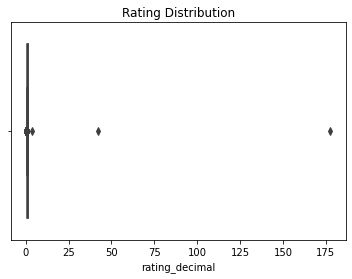

In [99]:
# rating box plot with outliers
ax = sns.boxplot(x=df_master["rating_decimal"], showfliers = True)
plt.title('Rating Distribution');

The plot confirms that there are few outliers that are wildly exaggerated from the majority of WeRateDogs tweets.
All dogs are good of course, however when raters get carried away with ratings, it makes rating system unreliable.

Now we will have a look what are the ratings for the tweets that are not outliers:

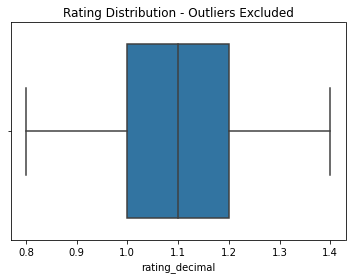

In [100]:
# rating box plot without outliers
ax = sns.boxplot(x=df_master["rating_decimal"], showfliers = False)
plt.title('Rating Distribution - Outliers Excluded');

**Insight 2:**
* WeRateDogs rating system is inconsistent and could be very subjective. 
* The hypothetical rating normal distribution suggests that majority of tweets were rated with rating numerator to rating denominator ratio between 1.0 and 1.2. 

### Can rating influence retweet and favourite count?

Next we will plot correlation between rating and retweet count as well as correlation between rating and favorite count

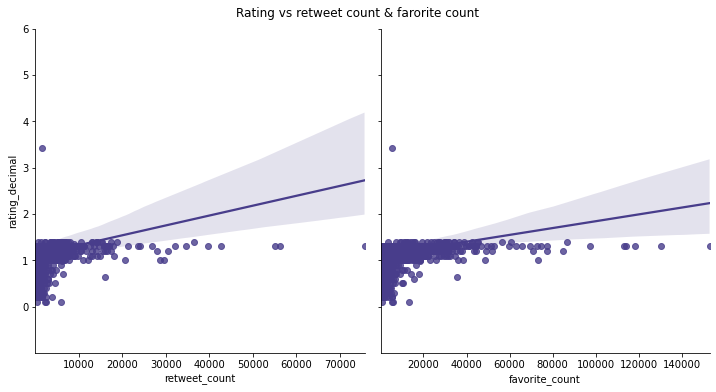

In [101]:
#Array with the column names for what we want to compare rating to
comparisons = ['retweet_count','favorite_count']
# create a grid to compare retweet and favorite counts that may correlate with rating
g = sns.PairGrid(df_master, y_vars=['rating_decimal'], x_vars=comparisons, height=5)
g.map(sns.regplot, color="darkslateblue")
g.set(ylim=(-1, 6), yticks=[0, 1, 2, 3, 4, 5, 6]);
g.fig.suptitle('Rating vs retweet count & farorite count', y=1.05);

**Insight 3:** 
There is weak positive correlation between rating and retweet count as well as with favourite count. However, there is no strong evidence that ranking on a tweet can drive retweets and favourite counts. 

### Rating and dog stage correlation

Now we will create bar plot to analyse if dog development stage can drive higher ratings:

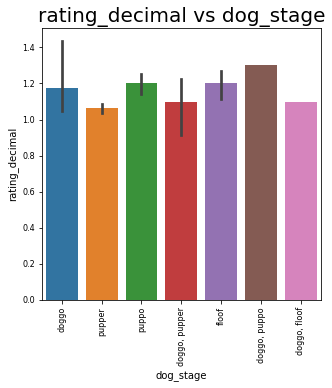

In [102]:
plot_categorical_data(df_master, 'rating_decimal', 'dog_stage', 2000, 5)

**Insight 4:** 
There is no strong evidence that dog development stage influences rating

### What are the most retweeted and likeable dog breeds in WeRateDogs archive?

#### Top 50 most likeable dog breeds

Next visualisation will be correlation between predicted dog breed (`best_prediction`) and favourite count. 
Note that due to wide range of breeds, only top 50 by favourite_count records were selected for plotting:

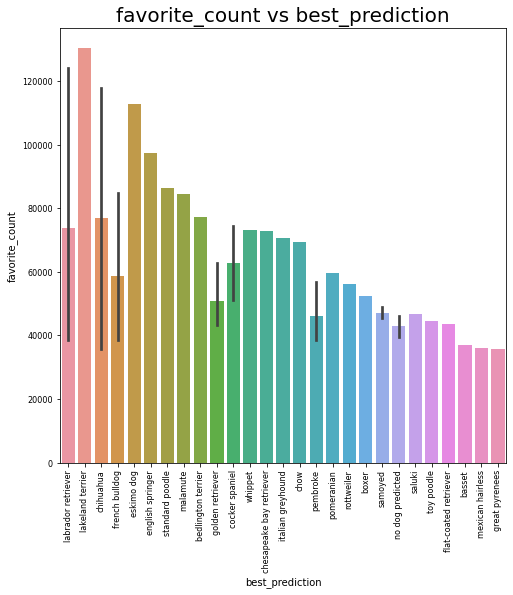

In [103]:
plot_categorical_data(df_master, 'favorite_count', 'best_prediction', 50, 8)

**Insight 5:** Interestingly, Labrador retriever is the most likeable dog breed, however the plot error bars suggest that this breed also has very high standard deviation for favorite count

#### Top 50 most retweeted tweets
Now we will see what are the predict dog breeds on tweets that were retweeted the most.
We only take 50 tweets with highest retweet count for plotting.

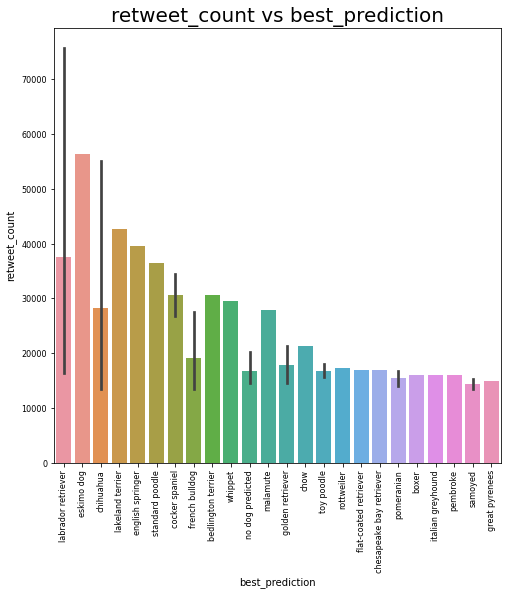

In [104]:
plot_categorical_data(df_master, 'retweet_count', 'best_prediction', 50, 8)

We see very similar correlation between dog breed and retweets number as between dog breed and favorite count.

Let's see if favorite count and retweet count are correlated:

/Users/olga/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


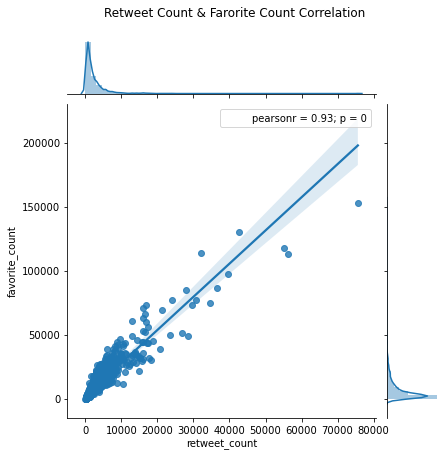

In [105]:
# use Seaborn joint plot to demonstrate correlation between two quantitive variables
g = sns.jointplot(data=df_master, x="retweet_count", y="favorite_count", kind="reg", stat_func=stats.pearsonr)
g.fig.suptitle('Retweet Count & Farorite Count Correlation', y=1.05);

**Insight 6**: Favorite count and retweet count are highly positively correlated with 0.93 Pearson coefficient.

### Analysis of image predictions
##### Correlation between prediction coefficients and number of images (`img_num`)

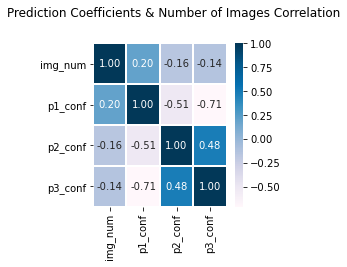

In [106]:
# correlation heatmap for img_num and prediction coefficients: 
f,ax = plt.subplots(figsize = (3,3))
g = sns.heatmap(df_master[['img_num','p1_conf', 'p2_conf', 'p3_conf']].corr(), 
            linewidths=.7, fmt = '.2f', annot = True,
            cmap='PuBu')
plt.suptitle('Prediction Coefficients & Number of Images Correlation', y=1.05);
plt.show()

**Insight 7:** 
There is no strong correlation between `img_num` and prediction confidence

#### What is distribution of three prediction coefficients? 
Next visualisations will help see if predictions get more stable with number of predictions

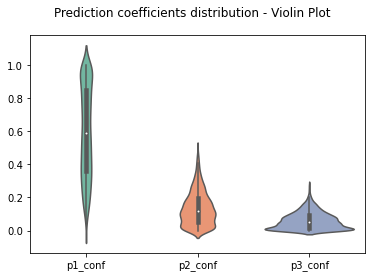

In [107]:
# violinplot for p1, p2, p3 confidence predictions
# this plot provides more information that a box plot would
ax = sns.violinplot(data=df_master[['p1_conf', 'p2_conf', 'p3_conf']], orient="w", palette="Set2")
plt.suptitle('Prediction coefficients distribution - Violin Plot');

**Insight 8:**
* first prediction: has much higher prediction range, although probability of these predictions are much narrower than p2 and p3 predictions
* second prediction: has higher probability that images in tweets will be predicted with p2 value
* third prediction has the highest probability that images will take on the given value in p3

This means that neural network is getting more stable with increasing number of trials.
However, this analysis did not take quality of the prediction into account.
As seen during assessment stage, some predictions with high confidence close to 1 predicted not a dog but other object on the supplied image.

#### Is number of trials improve prediction of a dog breed?
Let's assess if false dog predictions are reduced on third trial compared to second and first trial

In [108]:
# how many dogs were predicted on first trial
df_master['p1_dog'].value_counts()

True     1456
False     507
Name: p1_dog, dtype: int64

In [109]:
# how many dogs were predicted on second trial
df_master['p2_dog'].value_counts()

True     1472
False     491
Name: p2_dog, dtype: int64

In [110]:
# how many dogs were predicted on third trial
df_master['p3_dog'].value_counts()

True     1423
False     540
Name: p3_dog, dtype: int64

**Insight 9:**
No, as per descriptive statistics above there is no evidence that the neural network is improving on recognising dogs when first prediction could not recognise dogs on a given image.

This statement is based purely on descriptive statistics and shall be verified with a reliable model.

### Visualisation of most frequently used words in tweets' text

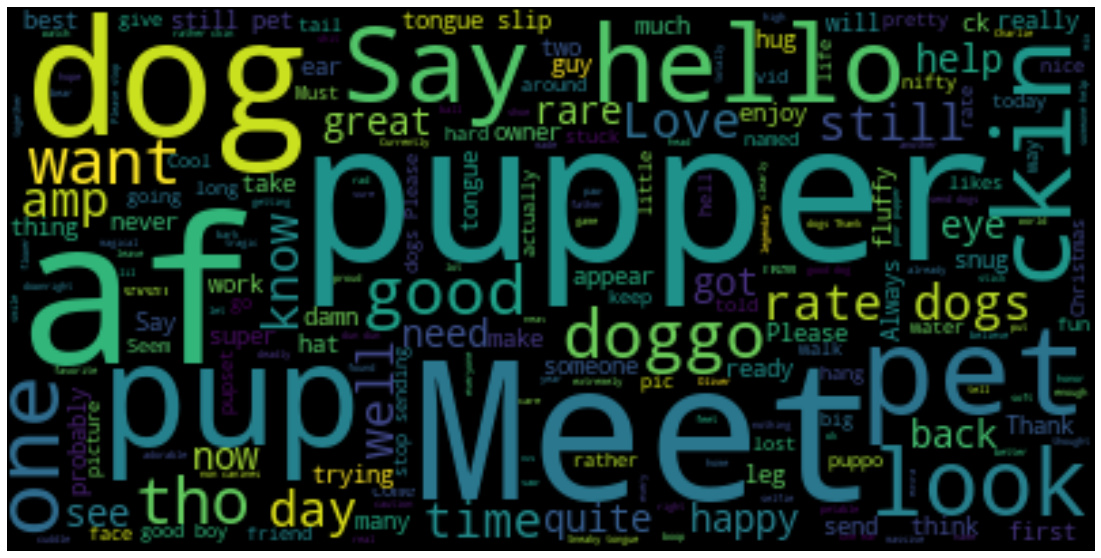

In [111]:
# generate word cloud from tweet text for a little bit of fun
# this code snippet was generated using two blog posts:
# 1. DataCamp: https://www.datacamp.com/community/tutorials/wordcloud-python
# 2. GoodDataAudience: https://blog.goodaudience.com/how-to-generate-a-word-cloud-of-any-shape-in-python-7bce27a55f6e

# create string from `text` column
text = ' '.join(df_master.text)

# create stop words list
stopwords = STOPWORDS
stopwords.update(['https', 'co'])


# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stopwords).generate(text)

# Display the generated image:
f,ax = plt.subplots(figsize = (20,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show();

## Conclusion

* WeRateDogs indeed uses a very unique rating system. This rating system however is not driven by specific factors in the data set but rather subjective to:
    * how cute dog on the tweet is, or 
    * is the picture emotionally moving or
    * personal opinion of a person who gives rating
* Interestingly, a Labrador retriever got the most likes and retweets     
* Neural network that was used for predicting dog breeds might need more training as number of images where dog was not determined did not decrease with number of trials. 
* A more sophisticated image recognising neural network would need to predict not only what dog breed is on a picture but also what makes the picture so likeable. This could help to predict what kind of pictures can get better engagement with the audience.